<a href="https://colab.research.google.com/github/LeyloJohnny/Type_of_pet/blob/main/WhatAmI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#hide
#!pip install --upgrade torch torchvision
#!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [5]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [22]:
key = os.environ.get('AZURE_SEARCH_KEY', '854cf690bd9c4537983454f3579c12ee')

In [40]:
pet_types = 'cat','dog', 'rabbit', 'mouse'
path = Path('pets')

In [39]:
#shutil.rmtree(path)

In [41]:
if not path.exists():
  path.mkdir()
  for o in pet_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{o} pets')
    download_images(dest, urls=results.attrgot('contentUrl'))

In [42]:
fns = get_image_files(path)
fns

(#567) [Path('pets/rabbit/00000051.jpg'),Path('pets/rabbit/00000020.jpg'),Path('pets/rabbit/00000071.jpg'),Path('pets/rabbit/00000008.jpg'),Path('pets/rabbit/00000138.jpg'),Path('pets/rabbit/00000021.jpg'),Path('pets/rabbit/00000135.jpg'),Path('pets/rabbit/00000107.jpg'),Path('pets/rabbit/00000062.jpg'),Path('pets/rabbit/00000129.jpg')...]

In [43]:
failed = verify_images(fns)
failed

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


(#4) [Path('pets/cat/00000141.jpg'),Path('pets/dog/00000135.jpg'),Path('pets/dog/00000024.jpg'),Path('pets/dog/00000115.jpg')]

In [44]:
failed.map(Path.unlink);

In [45]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

In [46]:
pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [47]:
#not necessary
dls = pets.dataloaders(path)

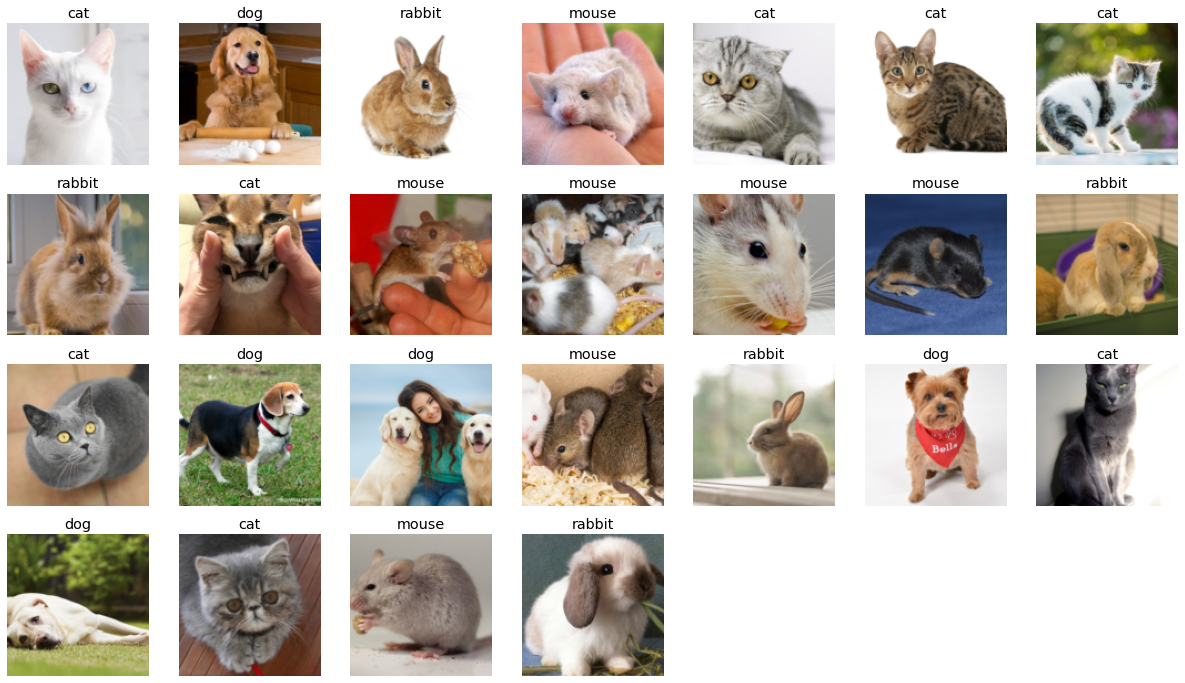

In [48]:
#not necessary
dls.valid.show_batch(max_n=25, nrows=4)

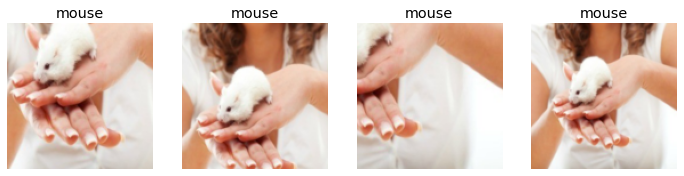

In [49]:
#not necessary
pets = pets.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = pets.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

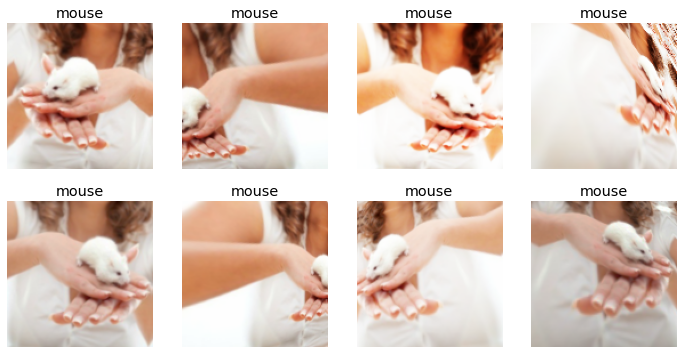

In [50]:
#not necessary
pets = pets.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = pets.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [51]:
pets = pets.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = pets.dataloaders(path)

In [52]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.684352,0.469011,0.133929,01:20


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.379090,0.379392,0.133929,01:41
1,0.293294,0.424720,0.151786,01:41
2,0.211349,0.437943,0.160714,01:42
3,0.171095,0.419736,0.151786,01:42


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes sh

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


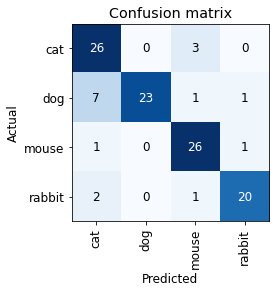

In [53]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

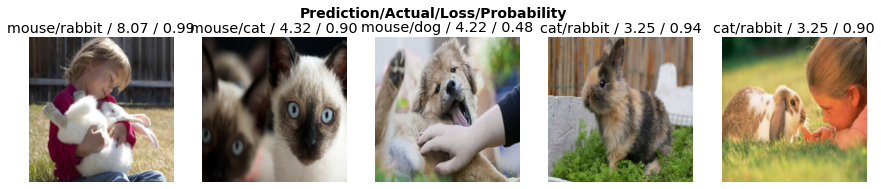

In [54]:
interp.plot_top_losses(5, nrows=1)

In [55]:
learn.export()

In [56]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [57]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
#!pip install voila
#!jupyter serverextension enable --sys-prefix voila 

In [60]:
from fastai.vision.widgets import *
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()

In [65]:
btn_run = widgets.Button(description='Classify')

In [66]:
btn_upload = widgets.FileUpload()

In [67]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [69]:
VBox([widgets.Label('Select your pet!'), 
      btn_upload, btn_run, out_pl, lbl_pred])